In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from scikitplot.metrics import plot_confusion_matrix
from scipy.stats import gaussian_kde

import Euclid

%erun Phosphoros 1.1

from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats

plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
tu_stars_path = '/home/aalvarez/Work/Data/SC8/EUC_MER_TU-STAR-CAT_TILE66929-WIDE_20210521T195819.266105Z_00.00.fits'
tu_gal_path = '/home/aalvarez/Work/Data/SC8/EUC_MER_TU-GALAXY-CAT_TILE66929-WIDE_20210521T200531.394565Z_00.00.fits'

mer_path = '/home/aalvarez/Work/Data/SC8/66929.fits'
phz_class_path = '/home/aalvarez/Work/Data/SC8/EUC_PHZ_CLASSCAT__20210707T205702.666944Z_00.00.fits'
phz_pdz_path = '/home/aalvarez/Work/Data/SC8/EUC_PHZ_PHZCAT__20210707T205659.021226Z_00.00.fits'
phz_pp_path = '/home/aalvarez/Work/Data/SC8/EUC_PHZ_PHYSPARAM__20210707T205702.257045Z_00.00.fits'

# Prepare MER

In [5]:
mer = Table.read(mer_path)
print('Original catalog: ', len(mer))

Original catalog:  57609


In [6]:
vis_det_mask = (mer['VIS_DET'] == 1)
print('Objects with no VIS detection: ', (~vis_det_mask).sum())
mer = mer[vis_det_mask]

Objects with no VIS detection:  13148


In [7]:
snr_mask = (mer['FLUX_DETECTION_TOTAL'] / mer['FLUXERR_DETECTION_TOTAL']) > 10
print('Objects with SNR < 10: ', (~snr_mask).sum())
mer = mer[snr_mask]

Objects with SNR < 10:  24927


In [8]:
print('Filtered catalog: ', len(mer))

Filtered catalog:  19534


# Prepare TU catalog

In [9]:
tu_stars = Table.read(tu_stars_path)
tu_gal = Table.read(tu_gal_path)
tu_gal.remove_columns(['RA', 'DEC'])
tu_gal.rename_columns(['RA_MAG', 'DEC_MAG'], ['RA', 'DEC'])
tu_stars.add_column(np.full(len(tu_stars), 1), name='OBJECT_TYPE')
tu_gal.add_column(np.full(len(tu_gal), 2), name='OBJECT_TYPE')

shared_cols = ['SOURCE_ID', 'RA', 'DEC', 'OBJECT_TYPE']
tu_all = vstack([tu_gal[shared_cols], tu_stars[shared_cols]])

WARN: MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Star Catalog' [astropy.utils.metadata]
WARN    : MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Star Catalog'
2021-07-08T15:22:00CEST astropy  WARN : MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Star Catalog'


In [11]:
tu_coords = SkyCoord(tu_all['RA'], tu_all['DEC'])
mer_coords = SkyCoord(mer['RIGHT_ASCENSION'], mer['DECLINATION'])
tu_idx, _, _, = match_coordinates_sky(mer_coords, tu_coords)

In [12]:
mer_tu = hstack([mer, tu_all[tu_idx]])

In [13]:
mer_gal_tu = join(mer_tu, tu_gal, 'SOURCE_ID')
mer_star_tu = join(mer_tu, tu_stars, 'SOURCE_ID')

WARN: MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Galaxy Catalog' [astropy.utils.metadata]
WARN    : MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Galaxy Catalog'
2021-07-08T15:22:23CEST astropy  WARN : MergeConflictWarning: Cannot merge meta key 'EXTNAME' types <class 'str'> and <class 'str'>, choosing EXTNAME='Galaxy Catalog'


# Classification

In [14]:
phz_class = Table.read(phz_class_path)

## Output

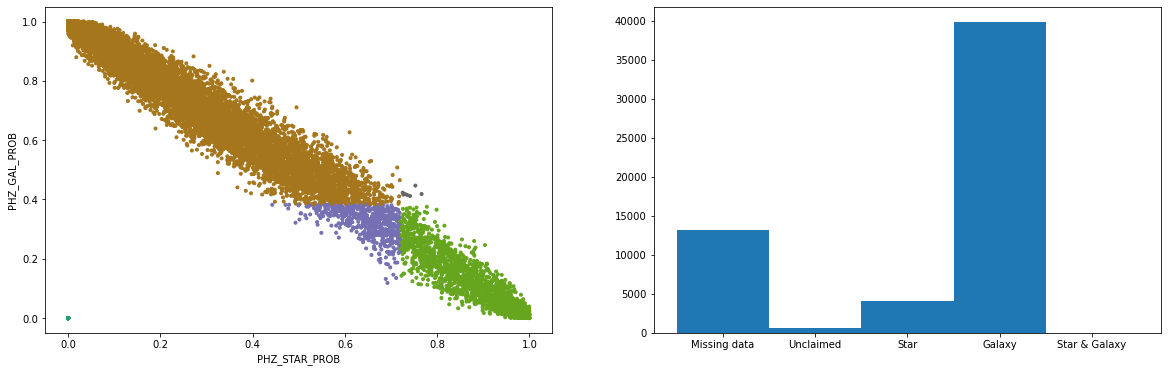

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
axes[0].scatter(phz_class['PHZ_STAR_PROB'], phz_class['PHZ_GAL_PROB'], marker='.', c=phz_class['CLASSIFICATION_FLAG'], cmap='Dark2')
axes[0].set_xlabel('PHZ_STAR_PROB')
axes[0].set_ylabel('PHZ_GAL_PROB')
axes[1].hist(phz_class['CLASSIFICATION_FLAG'], bins=[-1,0,1,2,3,4])
axes[1].set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5])
axes[1].set_xticklabels(['Missing data', 'Unclaimed', 'Star', 'Galaxy', 'Star & Galaxy'])
plt.show()

## Output vs Truth

In [16]:
classified_mask = np.in1d(phz_class['CLASSIFICATION_FLAG'], [1, 2, 3])
phz_class_tu = join(phz_class[classified_mask], mer_tu, 'OBJECT_ID')

<Figure size 864x432 with 0 Axes>

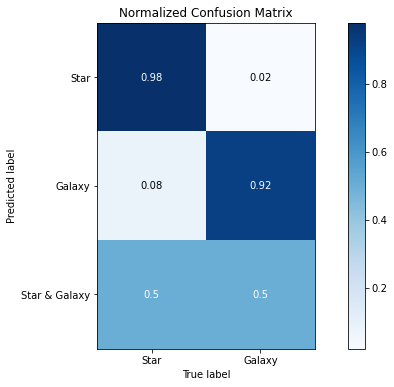

In [23]:
plt.figure()
ax = plot_confusion_matrix(
    phz_class_tu['CLASSIFICATION_FLAG'], phz_class_tu['OBJECT_TYPE'], normalize=True,
    true_labels=[1, 2, 3], pred_labels=[1, 2]
)
ax.set_xticklabels(['Star', 'Galaxy'])
ax.set_yticklabels(['Star', 'Galaxy', 'Star & Galaxy'])
# I have swapped since we care about the purity, not the precission
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
plt.savefig('/home/aalvarez/Downloads/66929_class.png')
plt.show()

# Photo-Z

In [18]:
phz_pdz = Table.read(phz_pdz_path, hdu=1)
phz_pdz = join(phz_pdz, mer_gal_tu, 'OBJECT_ID')
phz_pdz = phz_pdz[phz_pdz['PHZ_FLAGS'] == 0]

In [19]:
nan_phz = np.isnan(phz_pdz['PHZ_MEDIAN'])
print('Objects with NaN PHZ: ', nan_phz.sum())
phz_pdz = phz_pdz[~nan_phz]

Objects with NaN PHZ:  0


In [20]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phz_pdz['Z_OBS'], phz_pdz['PHZ_MEDIAN'])

--> Mean                :  -0.01192994
--> Median              :  -0.015517218
--> Sigma               :  0.21240535
--> Mad                 :  0.04082544
--> Outliers            :  14.519968262364454 %
--> Sigma (no outliers) :  0.03501818


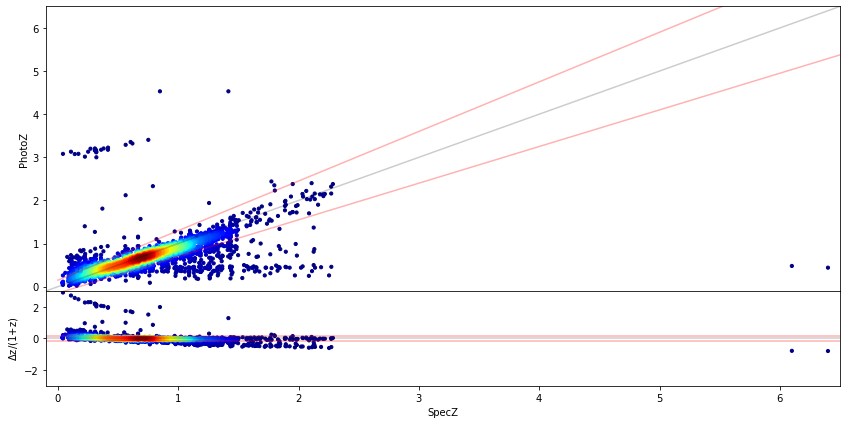

In [22]:
SpeczPhotozPlot(phz_pdz['OBJECT_ID'], phz_pdz['Z_OBS'], phz_pdz['PHZ_MEDIAN'], data)
plt.savefig('/home/aalvarez/Downloads/66929_pdz.png')
plt.show()

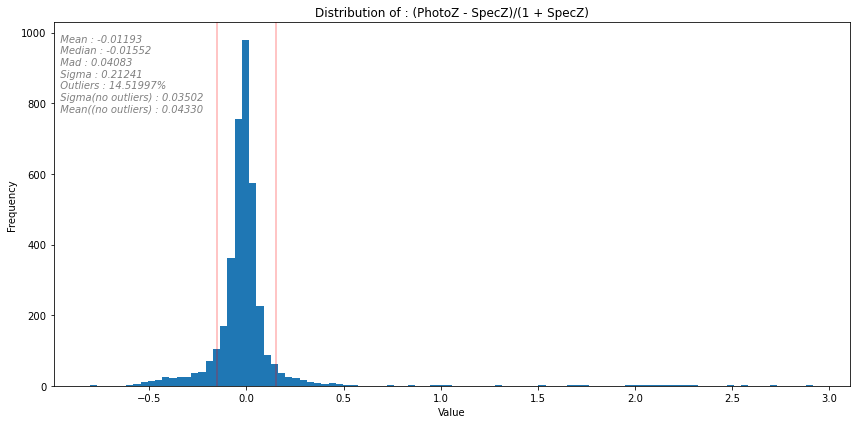

In [44]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers)
plt.savefig('/home/aalvarez/Downloads/66929_hist_dz.png')

# Physical parameters

## Redshift

In [25]:
phz_pp = Table.read(phz_pp_path)
phz_pp = join(phz_pp, mer_gal_tu, 'OBJECT_ID')
phz_pp = phz_pp[phz_pp['QUALITY_FLAG'] == 0]

In [26]:
nan_phz = np.isnan(phz_pp['PHZ_PP_MODE_Z'])
print('Objects with NaN PHZ: ', nan_phz.sum())
phz_pp = phz_pp[~nan_phz]

Objects with NaN PHZ:  0


In [27]:
pp_data, pp_mean, pp_median, pp_sigma, pp_mad, pp_outliersPercent, pp_sigmaNoOutliers, pp_meanNoOutliers = compute_stats(phz_pp['Z_OBS'], phz_pp['PHZ_PP_MODE_Z'])

--> Mean                :  0.031424347
--> Median              :  0.0015313186
--> Sigma               :  0.25572634
--> Mad                 :  0.053507555
--> Outliers            :  17.429682824655895 %
--> Sigma (no outliers) :  0.037932955


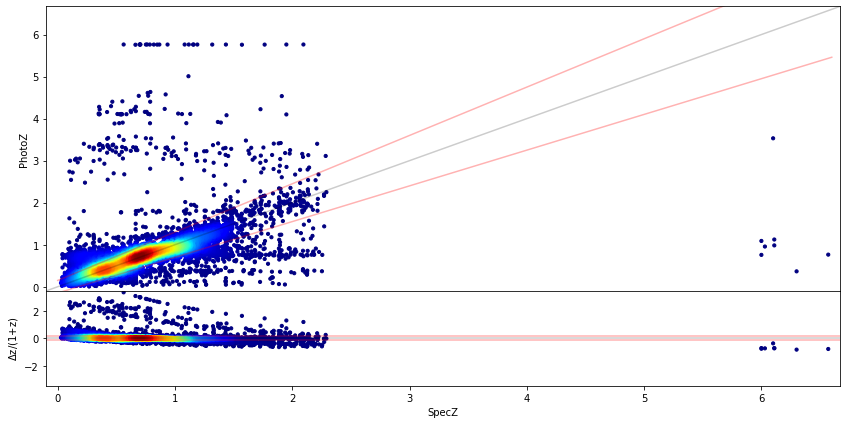

In [29]:
SpeczPhotozPlot(phz_pp['OBJECT_ID'], phz_pp['Z_OBS'], phz_pp['PHZ_PP_MODE_Z'], pp_data)
plt.savefig('/home/aalvarez/Downloads/6629_pp_z.png')
plt.show()

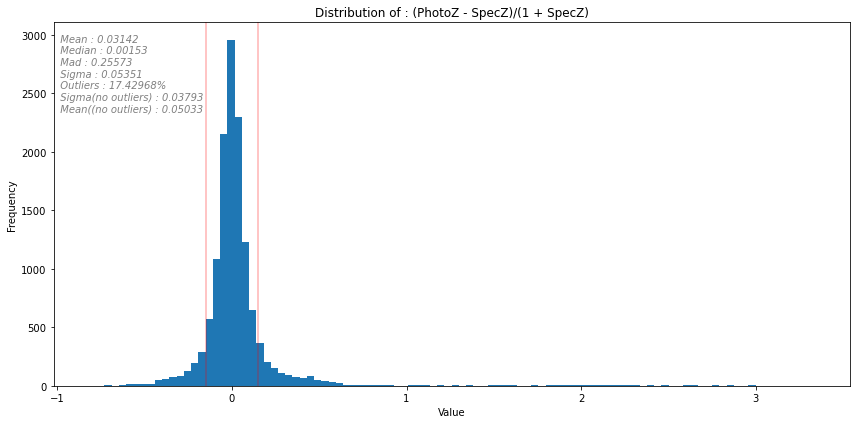

In [30]:
_ = displayHistogram(pp_data, pp_mean, pp_median, pp_sigma, pp_mad, pp_outliersPercent, pp_sigmaNoOutliers, pp_meanNoOutliers)

## Galaxy classification

Roughly

* From 0 to 8 elliptical
* From 9 to 19 spiral
* From 20 to 30 SB

In [31]:
SPIRAL_LMIN = 9
SB_LMIN = 19.5

phz_pp['TRUE_GALCLASS'] = 0
phz_pp['TRUE_GALCLASS'][(phz_pp['SED_TEMPLATE'] >= SPIRAL_LMIN)] = 1
phz_pp['TRUE_GALCLASS'][(phz_pp['SED_TEMPLATE'] >= SB_LMIN)] = 2

<Figure size 864x432 with 0 Axes>

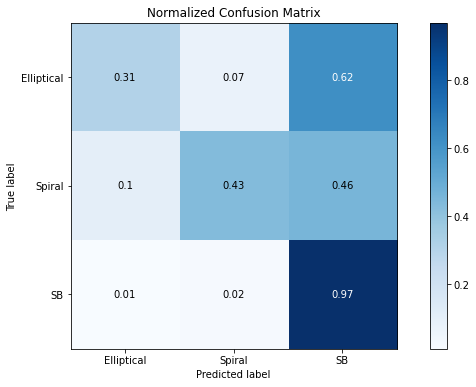

In [33]:
plt.figure()
ax = plot_confusion_matrix(phz_pp['GALAXY_CLASS'], phz_pp['TRUE_GALCLASS'], normalize=True)
ax.set_xticklabels(['Elliptical', 'Spiral', 'SB'])
ax.set_yticklabels(['Elliptical', 'Spiral', 'SB'])
plt.savefig('/home/aalvarez/Downloads/66929_pp_galclass.png')
plt.show()

In [34]:
def density_plot(a, b, ax=None):
    if not ax:
        ax = plt.gca()
    xy = np.vstack([a, b])
    density = gaussian_kde(xy)(xy)
    z_order = np.argsort(density)
    ax.scatter(a[z_order], b[z_order], c=density[z_order], cmap='jet', rasterized=True)

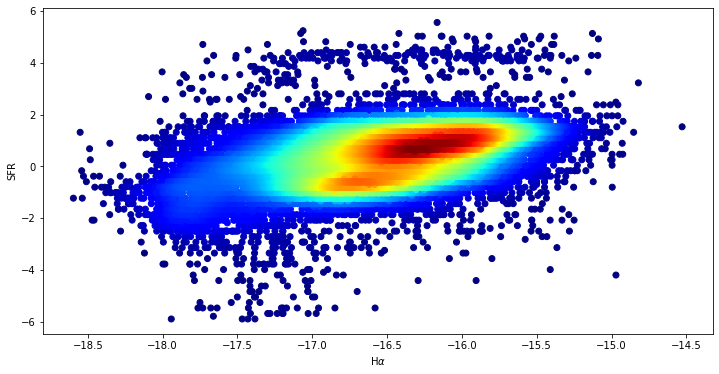

In [38]:
plt.figure()
mask = phz_pp['HALPHA_LOGFLAM_EXT_MAG']<-12
density_plot(phz_pp['HALPHA_LOGFLAM_EXT_MAG'][mask], phz_pp['PHZ_PP_MEDIAN_SFR'][mask])
plt.xlabel('H$\\alpha$')
plt.ylabel('SFR')
plt.savefig('/home/aalvarez/Downloads/66929_pp_SFR.png')
plt.show()

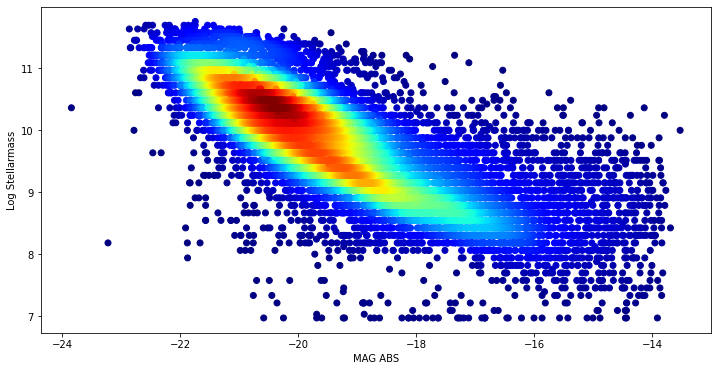

In [43]:
plt.figure()
density_plot(phz_pp['REF_MAG_ABS'], phz_pp['PHZ_PP_MEDIAN_LOG_STELLARMASS'])
plt.xlabel('MAG ABS')
plt.ylabel('Log Stellarmass')
plt.savefig('/home/aalvarez/Downloads/66929_mass.png')
plt.show()

# SEDs

## Stars

In [30]:
bands = [
    ('TU_FNU_U_LSST', 'lsst/u_MEAN'),
    ('TU_FNU_G_LSST', 'lsst/g_MEAN'),
    ('TU_FNU_R_LSST', 'lsst/r_MEAN'),
    ('TU_FNU_I_LSST', 'lsst/i_MEAN'),
    ('TU_FNU_Z_LSST', 'lsst/z_MEAN'),
    ('TU_FNU_VIS', 'euclid/VIS_MEAN'),
    ('TU_FNU_H_NISP', 'euclid/H_MEAN'),
    ('TU_FNU_J_NISP', 'euclid/J_MEAN'),
    ('TU_FNU_Y_NISP', 'euclid/Y_MEAN'),
]

In [31]:
phz_star_sed = Table.read(phz_star_sed_path)
phz_star_sed = join(phz_star_sed, mer_star_tu, 'OBJECT_ID')
phz_star_sed = phz_star_sed[phz_star_sed['FLAGS_1'] == 0]
len(phz_star_sed)

352

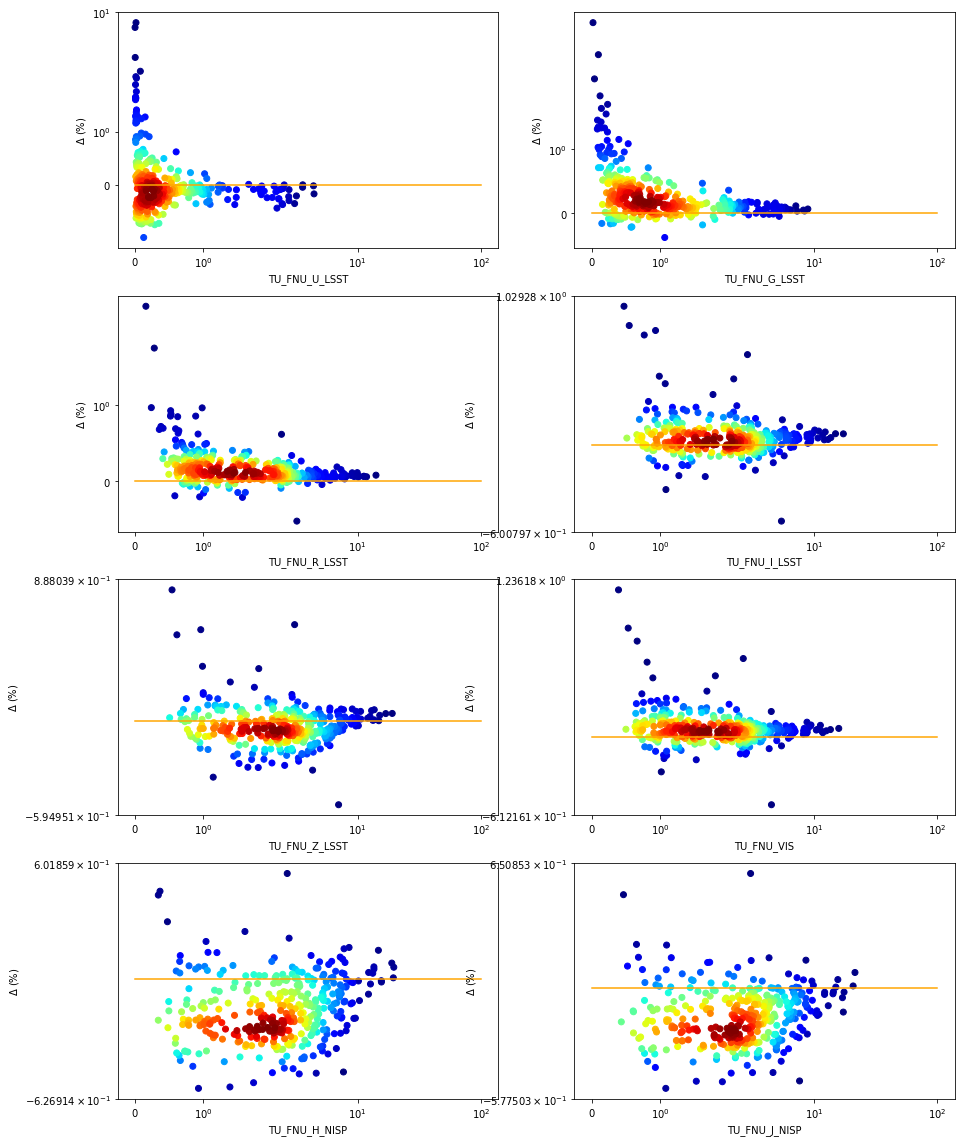

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2, figsize=(15, 20))

for (tb, ob), ax in zip(bands, axes.ravel()):
    density_plot(phz_star_sed[tb]*1e6, (phz_star_sed[ob]-(phz_star_sed[tb]*1e6))/(phz_star_sed[tb]*1e6), ax=ax)
    ax.plot([0, 1e2], [0, 0], c='orange')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel(tb)
    ax.set_ylabel('$\Delta$ (%)')
plt.show()

## Galaxies

In [33]:
phz_gal_sed = Table.read(phz_gal_sed_path)
phz_gal_sed = join(phz_gal_sed, mer_gal_tu, 'OBJECT_ID')
phz_gal_sed = phz_gal_sed[phz_gal_sed['FLAGS_1']==0]

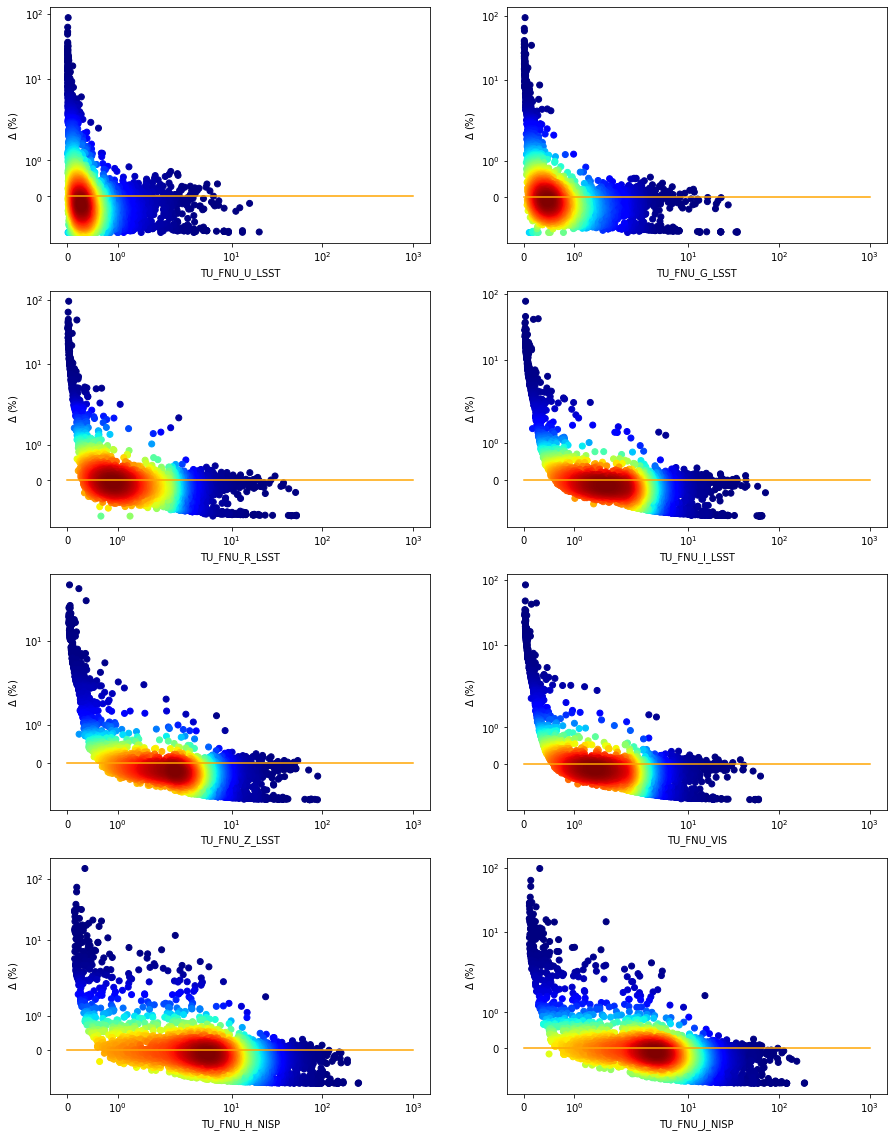

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2, figsize=(15, 20))

for (tb, ob), ax in zip(bands, axes.ravel()):
    density_plot(phz_gal_sed[tb]*1e6, (phz_gal_sed[ob]-(phz_gal_sed[tb]*1e6))/(phz_gal_sed[tb]*1e6), ax=ax)
    ax.plot([0, 1e3], [0, 0], c='orange')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlabel(tb)
    ax.set_ylabel('$\Delta$ (%)')
plt.show()